In [1]:
import os

In [2]:
data_dir = 'datasets/jena_climate'

In [3]:
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

In [4]:
f = open(fname)
data = f.read()
f.close()

In [5]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

In [6]:
print(header)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


In [7]:
print(len(lines))

420551


In [8]:
import numpy as np

In [9]:
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [10]:
import matplotlib.pyplot as plt

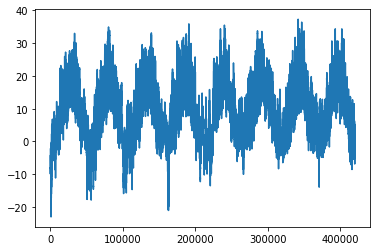

In [11]:
temp = float_data[:, 1] 
plt.plot(range(len(temp)), temp)

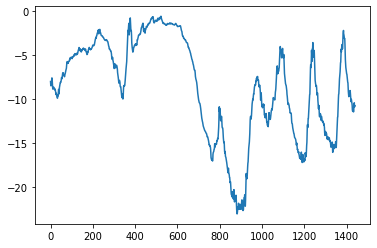

In [12]:
plt.plot(range(1440), temp[:1440])

In [13]:
mean = float_data[:200000].mean(axis=0)

In [14]:
float_data -= mean

In [15]:
std = float_data[:200000].std(axis=0)
float_data /= std

In [16]:
def generator(data, lookback, delay, min_index, max_index, shuffle = False, batch_size = 128, step = 6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size = batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
                rows = np.arange(i, min(i+ batch_size, max_index))
                i += len(rows)
                
        samples = np.zeros((len(rows),
                           lookback//step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [17]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

In [18]:
train_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=0,
                     max_index=200000,
                     shuffle=True,
                     step=step,
                     batch_size=batch_size)

In [19]:
val_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=200001,
                     max_index=300000,
                     shuffle=True,
                     step=step,
                     batch_size=batch_size)

In [20]:
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     shuffle=True,
                     step=step,
                     batch_size=batch_size)

In [21]:
val_steps = (300000 - 200001 - lookback)
test_steps = (len(float_data) - 300001 - lookback)

In [22]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

In [ ]:
evaluate_naive_method()

In [23]:
celsius_mae = 0.29* std[1]

In [24]:
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras import layers

Using TensorFlow backend.


In [26]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(1))
model.compile(optimizer= RMSprop(), loss= 'mae')
history = model.fit_generator(train_gen, steps_per_epoch = 500, epochs = 20, validation_data = val_gen, validation_steps = val_steps)

Epoch 1/20
500/500 [==============================] - 873s 2s/step - loss: 1.5958 - val_loss: 0.6037
Epoch 2/20
500/500 [==============================] - 984s 2s/step - loss: 0.5404 - val_loss: 0.3444
Epoch 3/20
500/500 [==============================] - 892s 2s/step - loss: 0.3101 - val_loss: 0.2915
Epoch 4/20
500/500 [==============================] - 932s 2s/step - loss: 0.2738 - val_loss: 0.3367
Epoch 5/20
500/500 [==============================] - 866s 2s/step - loss: 0.2570 - val_loss: 0.3203
Epoch 6/20
497/500 [============================>.] - ETA: 0s - loss: 0.2483

KeyboardInterrupt: 

In [27]:
import matplotlib.pyplot as plt

In [28]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_acc']

NameError: name 'history' is not defined

In [29]:
epochs = range(1, len(acc)+ 1)

NameError: name 'acc' is not defined

In [30]:
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

NameError: name 'epochs' is not defined

In [31]:
#First recurrent baseline

In [25]:
model = Sequential()
model.add(layers.GRU(32,input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer= RMSprop(), loss= 'mae')
history = model.fit_generator(train_gen, steps_per_epoch = 500, epochs = 20, validation_data = val_gen, validation_steps = val_steps)

Epoch 1/20
499/500 [============================>.] - ETA: 0s - loss: 0.3141

KeyboardInterrupt: 

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_acc']

In [ ]:
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
#Using recurrent dropout to fight overfitting

In [ ]:
model = Sequential()
model.add(layers.GRU(32, dropout = 0.2, recurrent_dropout= 0.2, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer= RMSprop(), loss= 'mae')
history = model.fit_generator(train_gen, steps_per_epoch = 500, epochs = 40, validation_data = val_gen, validation_steps = val_steps)

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_acc']

In [ ]:
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
#Stacked recurrent Neural neutworks

In [ ]:
model = Sequential()
model.add(layers.GRU(32, dropout = 0.1, recurrent_dropout= 0.5, return_sequences=True, input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation = 'relu', dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.compile(optimizer= RMSprop(), loss= 'mae')
history = model.fit_generator(train_gen, steps_per_epoch = 500, epochs = 40, validation_data = val_gen, validation_steps = val_steps)

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_acc']

In [ ]:
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
#Training and evaluating LSTMs using reversed sequences.

In [27]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

In [28]:
max_features = 10000
maxlen = 500

In [29]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

In [30]:
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

In [31]:
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

In [32]:
model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

In [33]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics = ['acc'])

In [34]:
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

/home/akshat/Documents/GHrepos/envs/ml_env/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 49s 2ms/step - loss: 0.4874 - acc: 0.7654 - val_loss: 0.3520 - val_acc: 0.8620
Epoch 2/10
20000/20000 [==============================] - 52s 3ms/step - loss: 0.3098 - acc: 0.8803 - val_loss: 0.4440 - val_acc: 0.8200
Epoch 3/10
20000/20000 [==============================] - 53s 3ms/step - loss: 0.2511 - acc: 0.9062 - val_loss: 0.3969 - val_acc: 0.8536
Epoch 4/10
 4608/20000 [=====>........................] - ETA: 36s - loss: 0.1861 - acc: 0.9332

KeyboardInterrupt: 

In [ ]:
#Training and evaluating bidirectional LSTMs

In [36]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                16640     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 336,705
Trainable params: 336,705
Non-trainable params: 0
_________________________________________________________________


In [37]:
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

/home/akshat/Documents/GHrepos/envs/ml_env/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
13312/20000 [==================>...........] - ETA: 13s - loss: 0.5979 - acc: 0.6868

KeyboardInterrupt: 

In [38]:
#Training and bidirectional GRU on temperature prediction task

In [39]:
model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32), input_shape = (None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mae')
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 64)                9024      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
_________________________________________________________________


In [40]:
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/40
155/500 [========>.....................] - ETA: 49s - loss: 0.3052

KeyboardInterrupt: 

In [23]:
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

In [25]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape = (None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout = 0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(optimizer=RMSprop(), loss = 'mae')

In [27]:
model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 37s 73ms/step - loss: nan - val_loss: nan
Epoch 2/20
500/500 [==============================] - 41s 81ms/step - loss: nan - val_loss: nan
Epoch 3/20
500/500 [==============================] - 40s 80ms/step - loss: nan - val_loss: nan
Epoch 4/20
500/500 [==============================] - 39s 78ms/step - loss: nan - val_loss: nan
Epoch 5/20
500/500 [==============================] - 40s 79ms/step - loss: nan - val_loss: nan
Epoch 6/20
500/500 [==============================] - 39s 79ms/step - loss: nan - val_loss: nan
Epoch 7/20
500/500 [==============================] - 39s 78ms/step - loss: nan - val_loss: nan
Epoch 8/20
500/500 [==============================] - 39s 79ms/step - loss: nan - val_loss: nan
Epoch 9/20
500/500 [==============================] - 39s 78ms/step - loss: nan - val_loss: nan
Epoch 10/20
500/500 [==============================] - 39s 79ms/step - loss: nan - val_loss: nan
Epoch 11/20
500/500 [==================

In [28]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_acc']

NameError: name 'history' is not defined

In [ ]:
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()